In [1]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import numpy as np
import warnings

In [2]:
# ปิดการแจ้งเตือนค่าคงที่
warnings.filterwarnings("ignore")

In [3]:
# Set the display options to prevent line wrapping and truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [4]:
data = pd.read_csv(r"csv\dataset_malwares.csv")

X = data.drop(['Name','Malware','SuspiciousImportFunctions','SuspiciousNameSection','TimeDateStamp'], axis=1)
y = data['Malware']

In [5]:
models = KNeighborsClassifier()

In [6]:
def anova_fvalue(k_mins, k_maxs, X, y, model, seed, cv):

    k_min = k_mins
    k_max = k_maxs

    results = []
    k_values = []
    accuracy_values = []

    f = open(f"result_text/anova/Anova_KNN_seed{seed}.txt", "w+")
    
    for k in range(k_min, k_max):

        selector = SelectKBest(f_classif, k=k)
        selector.fit(X, y)

        cols = selector.get_support(indices=True)

        X_select = X.iloc[:,cols]

        kf = KFold(n_splits=cv, random_state=seed, shuffle=True)

        scores = cross_val_score(model, X_select, y, cv=kf, scoring='accuracy')

        accuracy_score = scores.mean()

        k_values.append(k)
        accuracy_values.append(accuracy_score)
        results.append([k, accuracy_score])

        f.write('\n')
        f.write(f'ACC = {accuracy_score} K = {k} {X_select.columns.tolist()}')

    headers = ["K", "Accuracy"]
    f.write('\n')
    f.write(tabulate(results, headers, tablefmt="pretty"))
    f.close()

    plt.figure(figsize=(20, 6))
    plt.plot(k_values, accuracy_values, marker='.', linestyle='-')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title(f'Anova F-value - KNN, seed = {seed}')
    plt.xticks(range(k_min, k_max))
    plt.grid(True)

    save_path = f"result_graph/anova/Anova_KNN_seed{seed}"
    plt.savefig(save_path)
    plt.close()

    return k_values, accuracy_values, k_max, selector

In [7]:
def main():

    f = open(f"result_text/average_result/Anova_KNN_seed1-100.txt", "w+")    
    all_accuracy_values = []

    for seeds in range(1, 3):
        k_vals, acc_vals, k_maxs, selectors = anova_fvalue(k_mins=1, k_maxs=6, X=X, y=y, model=models, seed=seeds, cv=2)
        all_accuracy_values.append(acc_vals)

    all_accuracy_values_array = np.array(all_accuracy_values)

    average_accuracies = all_accuracy_values_array.mean(axis=0)

    features_score = pd.DataFrame(selectors.scores_)
    features_pvalue = pd.DataFrame(np.round(selectors.pvalues_,4))
    features = pd.DataFrame(X.columns)
    feature_score = pd.concat([features,features_score,features_pvalue],axis=1)

    feature_score.columns = ["Input_Features","Score","P_Value"]
    print(feature_score.nlargest(75,columns="Score"))
    f.write(feature_score.nlargest(75, columns="Score").to_string(index=False))

    average_results = list(zip(range(1, k_maxs + 1), average_accuracies))
    headers = ["K", "Average Accuracy 1-100 seed"]

    print('\n')
    print(tabulate(average_results, headers, tablefmt="pretty"))

    f.write('\n')
    f.write(tabulate(average_results, headers, tablefmt="pretty"))
    f.close()
    
    plt.figure(figsize=(20, 6))
    plt.plot(k_vals, average_accuracies, marker='.', linestyle='-')
    plt.xlabel('k')
    plt.ylabel('Average Accuracy 1-100 seed')
    plt.title(f'Anova F-value - KNN, Sample group 100 seeds')
    plt.xticks(range(1, k_maxs))
    plt.grid(True)
    save_path = f"result_graph/average_result/Anova_KNN_seed1-100"
    plt.savefig(save_path)
    plt.show()

                  Input_Features         Score  P_Value
38         MajorSubsystemVersion  11719.271946   0.0000
43                     Subsystem   6289.935175   0.0000
64                SectionMaxChar   3587.877130   0.0000
23                         Magic   1765.696809   0.0000
17                       Machine   1765.683619   0.0000
21          SizeOfOptionalHeader   1371.683151   0.0000
45            SizeOfStackReserve   1327.332052   0.0000
32              SectionAlignment    878.382920   0.0000
44            DllCharacteristics    791.924505   0.0000
6                     e_maxalloc    703.319147   0.0000
33                 FileAlignment    604.447342   0.0000
25            MinorLinkerVersion    426.183305   0.0000
41                      CheckSum    365.796078   0.0000
24            MajorLinkerVersion    356.049491   0.0000
66          DirectoryEntryImport    328.670550   0.0000
22               Characteristics    280.049579   0.0000
18              NumberOfSections    237.411709  

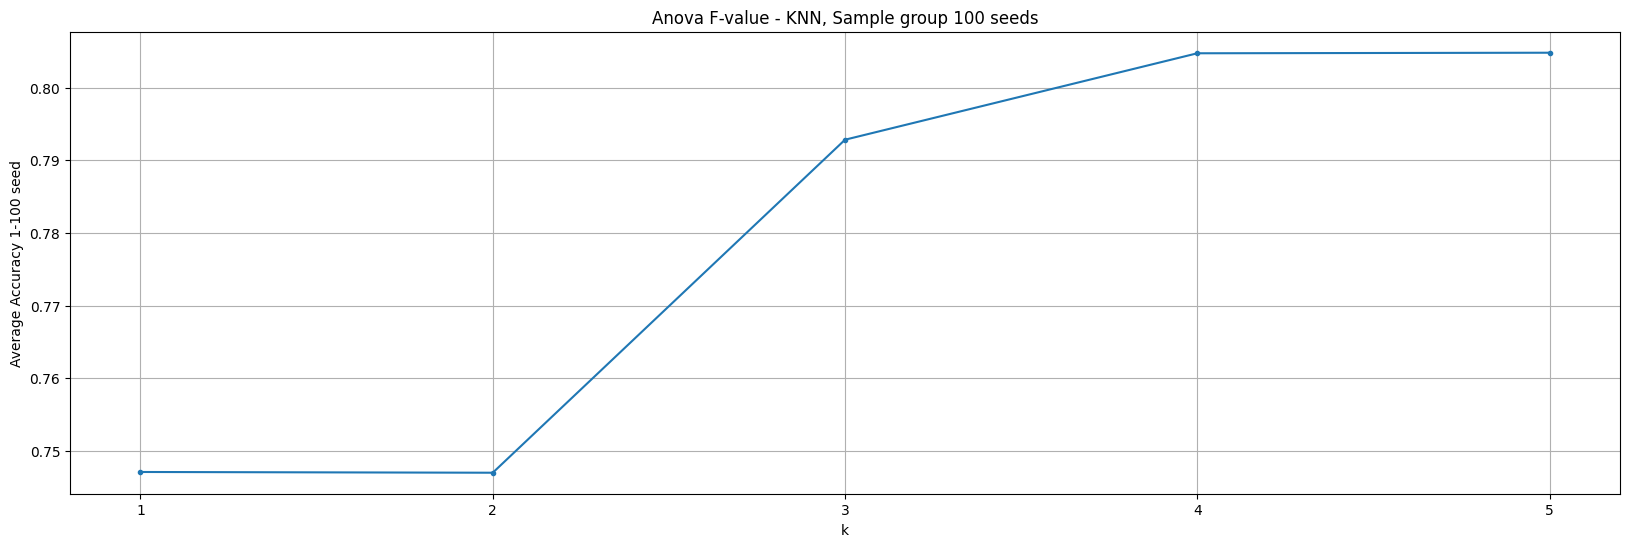

In [8]:
main()